# **English to Dutch Neural Machine Translation**

By : Muhammad Fawwaz Dynoeputra Isnandar
- Using deep learning sequence 2 sequence LSTM model, we want to create a **Neural Machine Translation** inspired by google and creating a English to Dutch translation machine.

## **OBJECTIVES**
This project objectives are :
- Able to grasp the concept of Computer Vision/NLP.
- Able to prepare the data to be used inside the Computer Vision/NLP model.
- Able to implement Artificial Neural Networks with the existing data
- Able to analyze and elaborate the layers that's been made

## **PROBLEM STATEMENT**

Inspired by Google Translate and Microsoft Bing Translate, we want to create a translation model using python. Although there are already libraries available to use on *Neural Machine Translation*, we want to achieve the same results of using TensorFlow by implementing a SEQUENCE2SEQUENCE model using *Recurrent Neural Networks*. 

# **WORKING AREA**

## **ABOUT THE DATASET**

[DATASET](http://www.manythings.org/anki/)

The dataset that we'll be using is attained from the above links. This website provides a number of dataset translation from English to other languages. For this project, we are going to use the ENGLISH to DUTCH translation dataset that has **70.549** total entries of translations.

## **IMPORTING LIBRARIES**

First things first, we want to import the libraries for us to be able to work on this assignment:

In [1]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

Then we want to retrieve the dataset from our said links using the bash command as seen below:

In [2]:
!wget http://www.manythings.org/anki/nld-eng.zip -O nld-eng.zip
!unzip nld-eng.zip

--2022-12-12 06:44:54--  http://www.manythings.org/anki/nld-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2507659 (2.4M) [application/zip]
Saving to: ‘nld-eng.zip’

nld-eng.zip         100%[===================>]   2.39M  1.67MB/s    in 1.4s    

2022-12-12 06:44:56 (1.67 MB/s) - ‘nld-eng.zip’ saved [2507659/2507659]

Archive:  nld-eng.zip
  inflating: _about.txt              
  inflating: nld.txt                 


Then we want to read our dataset into this notebook, and then deleting unused columns as you can see below:

In [3]:
df = pd.read_table( 'nld.txt' , names=[ 'eng' , 'nld' ] )
df.reset_index( level=0 , inplace=True )
df.rename( columns={ 'index' : 'eng' , 'eng' : 'nld' , 'nld' : 'c' } , inplace=True )
df = df.drop( 'c' , 1 )
df = df.iloc[ 20000 : 40000 ] 
df.head()


,eng,nld
20000,What's wrong with it?,Wat is er mis mee?
20001,What's your nickname?,Wat is jouw bijnaam?
20002,What's your nickname?,Wat is uw bijnaam?
20003,What's your password?,Wat is je wachtwoord?
20004,What's your password?,Wat is jouw wachtwoord?


For computational limitation purposes, we only used a total of **20.000** entries of data so it doesnt cost our computational performances. **Next**, we want to make sure the total data is as we wanted which is **20.000**

In [4]:
print(f'English total data :' , len(df['eng']))
print(f'Dutch total data :', len(df['nld']))

English total data : 20000
Dutch total data : 20000


Then we want to check if there are any missing values in this dataset that we sliced earlier:

In [5]:
df.isnull().sum()

eng    0
nld    0
dtype: int64

Turns out there's no missing values. Let's check if there are any data duplicates within this dataset:

In [6]:
df.duplicated().sum()

0

Looks good! we have no missing values and data duplicates.

## **EXPLORATORY DATA ANALYSIS**

> In this section we want to explore our data further in order to understand our data and be more precise with our next step going further into this project.

Next we want to find out the total population of sentence lengths within each languages with the help of the loop seen below:

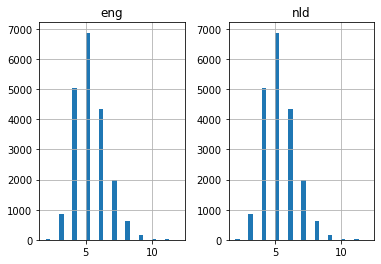

In [7]:
eng_l = []
nld_l = []

# populate the lists with sentence lengths
for i in df.nld :
      eng_l.append(len(i.split()))

for i in df.nld:
      nld_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'nld':nld_l})

length_df.hist(bins = 30)
plt.show()

We saw some pretty long lengths of sentences in both languages, and both has approximately the same distribution of sentence lengths within this dataset. **Next**, we want to find out the representations of word frequency that give greater prominence to words that appear more frequently in a source text. This is achieved using the a library from **WordCloud**. WordCloud or tag clouds are graphical representations of a word frequency that gives greater prominance to words that appear more frequently. We want to start from the **English** language first:

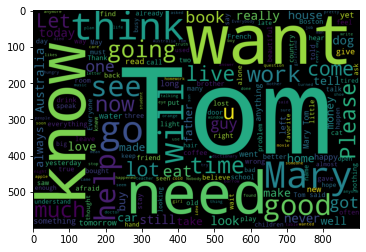

In [8]:
wc = WordCloud(width=900,height=600).generate(' '.join(df.eng))
plt.imshow(wc);

We can see that `'Tom'`, `'Know'`, `'want'`, `'need'`, `'think'` and `'good'` appear frequently from this dataset. Let's head on to the next language **Dutch**:

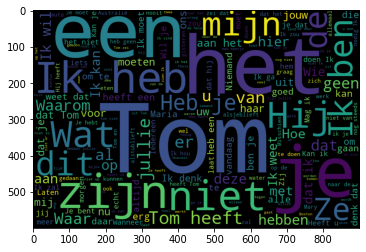

In [9]:
wc = WordCloud(width=900,height=600).generate(' '.join(df.nld))
plt.imshow(wc);

From the **Dutch** we could see that the same `'Tom'` word reapearring frequently, as well as `'een'` which in english is `'a'`, `'het'` in english is `'the'`, `'zijn'` in english is `'to be'`, `'niet'` in english is `'not'`, `'Wat'` in english is `'what'`, `'heb'` is `'have'`. 

Now, **Off to the next section**!

## **DATA CLEANING**

> In this section we want to make sure that our data is well cleaned and prepared to be processed by our Deep Learning models.

The first thing we want to do is we want to make a function to clean our data entries (text). Within this function lies a function to :
- lowercase our text. The reasoning for this is our model couldn't read case sensitive text and will recognize it as a different pattern. Hence why we make all the data entries lowercase.
- We want to make an regular expression method and compile a pattern which matches any character which is not a word character.
- Then we want to replace the specified pattern in our previous code to be then replaced by the replacement string and be removed.
- Then we want to remove the punctuation characters from our dataset as it doesn't represent anything.
- Then we want to remove the whitespaces from our dataset as it's not good for our model to learn on.

In [10]:
def clean_text(text):
    text = text.lower()  
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    text = re.sub('([.,!?()\"])', r' \1 ', text)
    text = re.sub('\s{2,}', ' ', text)
    return text

After the function has been created, we apply them to both our languages as seen below:

In [11]:
df.eng = df.eng.apply(clean_text)
df.nld = df.nld.apply(clean_text)

In the code seen below, we want to make sure that our previous data cleaning has taken effect:

In [12]:
df.nld.head()

20000         wat is er mis mee
20001       wat is jouw bijnaam
20002         wat is uw bijnaam
20003      wat is je wachtwoord
20004    wat is jouw wachtwoord
Name: nld, dtype: object

In [13]:
df.eng.head()

20000    what s wrong with it
20001    what s your nickname
20002    what s your nickname
20003    what s your password
20004    what s your password
Name: eng, dtype: object

Off to the next section!

### **Preparing the Input Data For the Encoder**

> In this section we want to prepare our encoder to then be supplied by inputs. In our case we want our english and dutch languages to be preprocessed before it will be fed to the model.

#### **ENGLISH**

First, we want to tokenize our english language. Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning using the code as you can see below:

In [14]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df.eng)

#finding our vocabulary sizes
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

4966

Then we want to find out our total vocabulary sizes in the english language. Vocabulary is a unique representation of tokens. In the english language, the total of vocab size is **4966**. Next, we want to transform each text in texts to a sequence of integers so we could determine the maximum lengths of a single sequence in english language:

In [15]:
eng_sequences = eng_tokenizer.texts_to_sequences(df.eng)
length_list = []
for i in eng_sequences:
    length_list.append(len(i))
    
max_input_length = np.array(length_list).max()
print( 'English max length is {}'.format( max_input_length ))


English max length is 9


Here we could see that the maximum length of the english language is 9. After that we want to save our model in order to use it in our deployment later:

In [16]:
pickle.dump(eng_tokenizer, open('eng_tokenizer.pkl', 'wb'))

#### **DUTCH**

In our target translation language which is dutch, we want to apply an start and endpoint since the dutch language will start to execute after the english language has been inputed. This is important so then our model isnt confused by mixing up the languages later into our modelling.

In [17]:
dutch_dec = df['nld'].apply(lambda x: '<START> ' + x + ' <END>')

Then we want to do the same thing as we did on the english language, which is tokenizing on sentences, finding out total vocabulary sizes and determining the max length of the **Dutch** language.

In [18]:
nld_tokenizer = Tokenizer()
nld_tokenizer.fit_on_texts(dutch_dec)

In [19]:
nld_vocab_size = len(nld_tokenizer.word_index) + 1
nld_vocab_size

6688

In [20]:
nld_sequences = nld_tokenizer.texts_to_sequences(dutch_dec)
length_list = []
for i in nld_sequences:
    length_list.append(len(i))
    
max_input_length = np.array(length_list).max()
print( 'Dutch max length is {}'.format( max_input_length ))

Dutch max length is 14


As you can see we could see that the **Dutch** language has higher count of vocabulary and max lengths. The important note is we want to find the max lengths so we could determine the padding later into this section. In our code below is we want to save our dutch tokenizer for us to use into our inference later:

In [21]:
pickle.dump(nld_tokenizer, open('nld_tokenizer.pkl', 'wb'))

#### **DETERMINING THE MAX LENGTH**

Now we know our max lengths of both languages, it's time for us to determine our max lengths as we want our model to perform good, and using an undetermined max length could result in a worse performing model.

In [22]:
# Determining the max length of both languages based on the most length
max_eng_len = 14
max_nld_len = 14

#### **PADDING ON BOTH INPUT ENCODER & DECODER**

The next thing we want to do is we want to pad both of our languages as we explained before in determining the max lengths. This is possible by using the `pad_sequences` from tensorflow. `pad_sequences` is used to ensure that all sequences in a list have the same length. And also a Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length :

In [23]:
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')
nld_pad_sequences = pad_sequences(nld_sequences,maxlen=max_nld_len,dtype='int32',padding='post',truncating='post')

### **DATA SPLITTING**

Next, we want to split our data into train and tests so we could see and evaluate the performances of our model, here we want to use a test size of `25%`, meaning we have `75%` of training data.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(eng_pad_sequences,nld_pad_sequences,test_size=0.25,shuffle=True,random_state=42)


In [25]:
print(f'X_train shape : ',X_train.shape)
print(f'X_test shape : ',X_test.shape)
print(f'y_train shape : ',y_train.shape)
print(f'y_test shape : ',y_test.shape)

X_train shape :  (15000, 14)
X_test shape :  (5000, 14)
y_train shape :  (15000, 14)
y_test shape :  (5000, 14)


## **WHAT IS SEQUENCE 2 SEQUENCE MODELLING?**

* Sequence-to-Sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to German).
* Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, DNA sequence modeling, among others.
* For this particular project, we are using the sequence-to-sequence encoder - decoder model. What does the encoder & decoder do? 
    - Encoder : reads and encodes a source sentence into a fixed length vector
    - Decoder : Decoder then outputs a translation from the encoded vector (or known as context vectors)
* We also want to use the LSTM which which acts as the algorithm for our encode and decoding. The LSTM is a particular recurrent neural architecture independent of any application. It can be used for general sequence processing problems, from sequence classification to sequence transcoding and more. LSTMs can also be used to implement NMT, and they are an effective architecture for that purpose.


## **BASE MODEL ARCHITECTURE**

> In this section we want to define our base model architecture so we could see the baseline benchmark of the performances of our model. This baseline benchmark will then be improved later into our project.

Here we want to define our lstm dimensions and embedding demensions. Here we set the LSTM layer to be as much as 64, and embedding dimensions as much as 16. **Embedding** is a term used for the representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning. An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words.

In [26]:
#model architecture
K.clear_session()

latent_dim = 64 
embedding_dim = 16

encoder_inputs = Input(shape=(None,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(nld_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 


decoder_dense = TimeDistributed(Dense(nld_vocab_size,activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

base_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
base_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 16)     79456       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 16)     107008      ['input_2[0][0]']                
                                                                                              

Here we could see that we have 2 inputs. 1 for the encoder and 1 for the decoder. In each inputs we want to embed the inputs into vectors. We also used the `TimeDistributed` dense layer for our output because an time distributed dense layer takes a batch size by sequence length by input size array and produces a batch size by sequence length by number of classes size array, and we'll use the `softmax` activation because `Softmax` is a mathematical function that converts a vector of numbers into a vector of probabilities. In this particular model we also want to save the hidden and cell states of the LSTM from the encoder because we need the context vectors to be then predicted and processed by the decoder. The end result is the sentences of our input will then be sorted by our final decoder lstm and dense layer., The clearer representation can be seen in our plot model below:

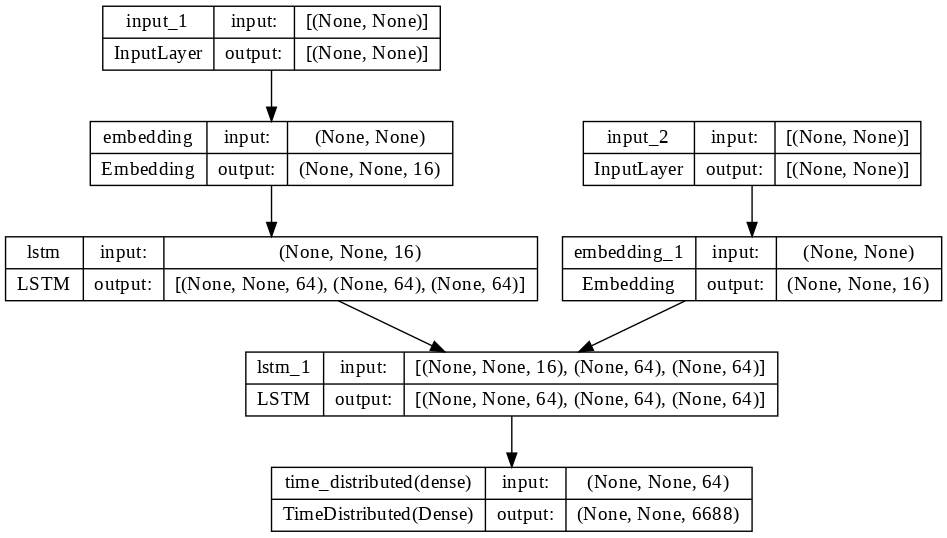

In [27]:
plot_model(base_model,'base_model.png',show_shapes=True,dpi=100)

We want to compile the model and use the `sparse_categorical_crossentropy` loss function. The reasoning for this is because our variables is not one-hot encoded, if it's one hot encoded we will use the usual `categorical_crossentropy`. Since we convert them into integers with embedding, we'll use the `sparse_categorical_crossentropy`. We also want to use the `SGD` Optimizer because it tries to find minimum or maximum error via iteration.

In [28]:
base_model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics='accuracy')

#### **BASE MODEL TRAINING**

Let's start our training and applying an early stopping and reducing the learning rate if the model doesn't improves. We will also use 20 iterations and due to our computational limitations, we'll use the batch size of 64.

In [29]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=3,factor=0.1,min_lr=0.001)

base_model_r = base_model.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=20,
             batch_size=64,
             callbacks=[es,rl],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/20
235/235 [==============================] - 15s 31ms/step - loss: 8.4723 - accuracy: 0.5186 - val_loss: 8.1179 - val_accuracy: 0.5212 - lr: 0.0100
Epoch 2/20
235/235 [==============================] - 4s 19ms/step - loss: 7.5489 - accuracy: 0.5208 - val_loss: 6.4249 - val_accuracy: 0.5212 - lr: 0.0100
Epoch 3/20
235/235 [==============================] - 4s 18ms/step - loss: 4.7494 - accuracy: 0.5208 - val_loss: 4.2863 - val_accuracy: 0.5212 - lr: 0.0100
Epoch 4/20
235/235 [==============================] - 4s 18ms/step - loss: 4.2056 - accuracy: 0.5208 - val_loss: 4.1248 - val_accuracy: 0.5212 - lr: 0.0100
Epoch 5/20
235/235 [==============================] - 4s 18ms/step - loss: 4.0539 - accuracy: 0.5208 - val_loss: 3.9802 - val_accuracy: 0.5212 - lr: 0.0100
Epoch 6/20
235/235 [==============================] - 4s 18ms/step - loss: 3.9342 - accuracy: 0.5208 - val_loss: 3.9019 - val_accuracy: 0.5212 - lr: 0.0100
Epoch 7/20
235/235 [==============================] - 4s 18ms/s

Let's visualize in order to evaluate our models:

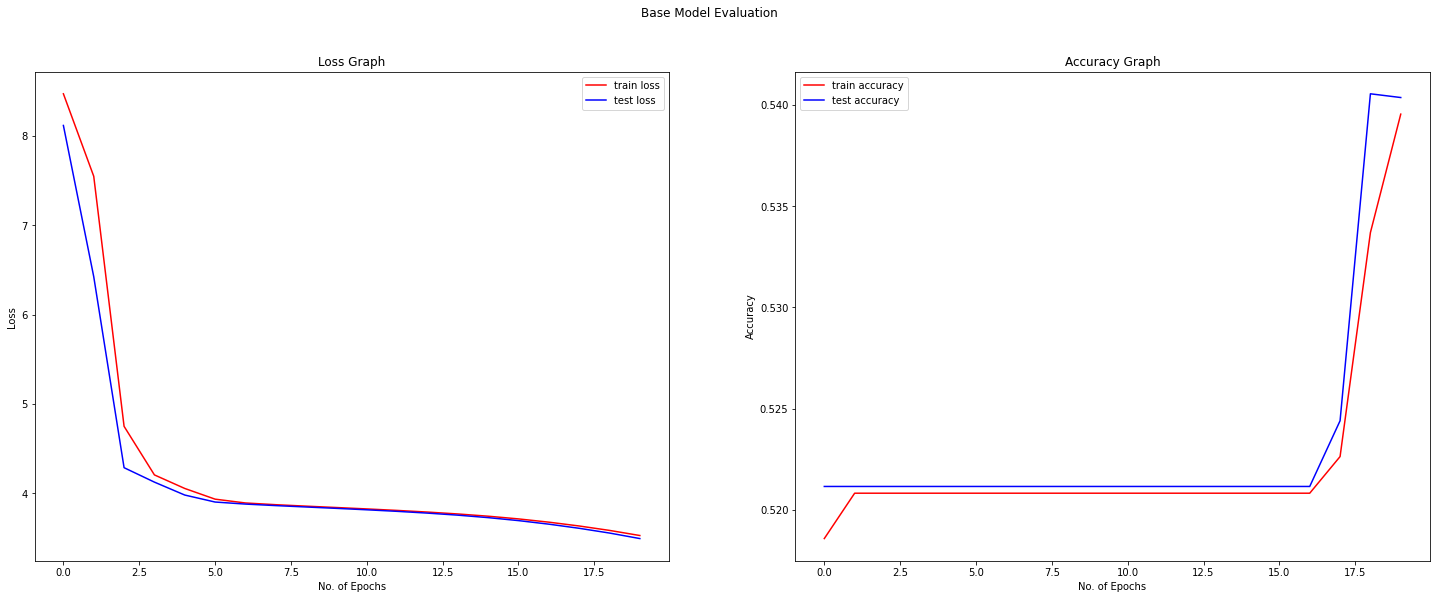

In [30]:
fig, ax = plt.subplots(1,2, figsize=(25,9))
plt.suptitle('Base Model Evaluation')

plt.subplot(1,2,1)
plt.plot(base_model_r.history['loss'],'r',label='train loss')
plt.plot(base_model_r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

plt.subplot(1,2,2)
plt.plot(base_model_r.history['accuracy'],'r',label='train accuracy')
plt.plot(base_model_r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

plt.show()

The results are pretty good in terms of consistency, but we still have a high loss and low accuracy (**3.520** & **0.5404**). Let's try to improve in our next model:

### **IMPROVEMENT MODEL ARCHITECTURE**

> As explained above, we want to improve our model from our baseline benchmark model. 

We want to add the embedding dimensions in our improved model, then add some batch normalizations as well as adding dropout layers into our LSTM model in hopes of getting better overal consistency and better accuracy and losses:

In [31]:
#model architecture
K.clear_session()

latent_dim = 64
embedding_dim = 32

encoder_inputs = Input(shape=(None,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_BN_2 = BatchNormalization()(encoder_emb)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_BN_2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(nld_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_BN_3 = BatchNormalization()(decoder_emb)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_BN_3, initial_state=encoder_states) 

decoder_dense = TimeDistributed(Dense(nld_vocab_size,activation='softmax'))
decoder_output = decoder_dense(decoder_outputs)

model_imp = Model([encoder_inputs, decoder_inputs], decoder_output)
model_imp.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     158912      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     214016      ['input_2[0][0]']                
                                                                                              

Here is some short explanations of each improvements that we did to our model :

**BATCH NORMALIZATION**
* Batch normalization is a technique to standardize the inputs to a network, applied to ether the activations of a prior layer or inputs directly.
* Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error.

**DROPOUT**
* dropout, which we'll cover in more detail at a later time, is a regularization technique that randomly ignores a subset of nodes in a given layer. It essentially prevents these dropped out nodes from participating in producing a prediction on the data.
* When using dropout, we can specify a percentage of the nodes we want to drop. So if we're using a 50% dropout rate, and we see that our model is underfitting, then we can decrease our amount of dropout by reducing the dropout percentage to something lower than 50 and see what types of metrics we get when we attempt to train again.
* These nodes are only dropped out for purposes of training and not during validation. So, if we see that our model is fitting better to our validation data than it is to our training data, then this is a good indicator to reduce the amount of dropout that we're using.

Let's the the visualizations of our improved model below:

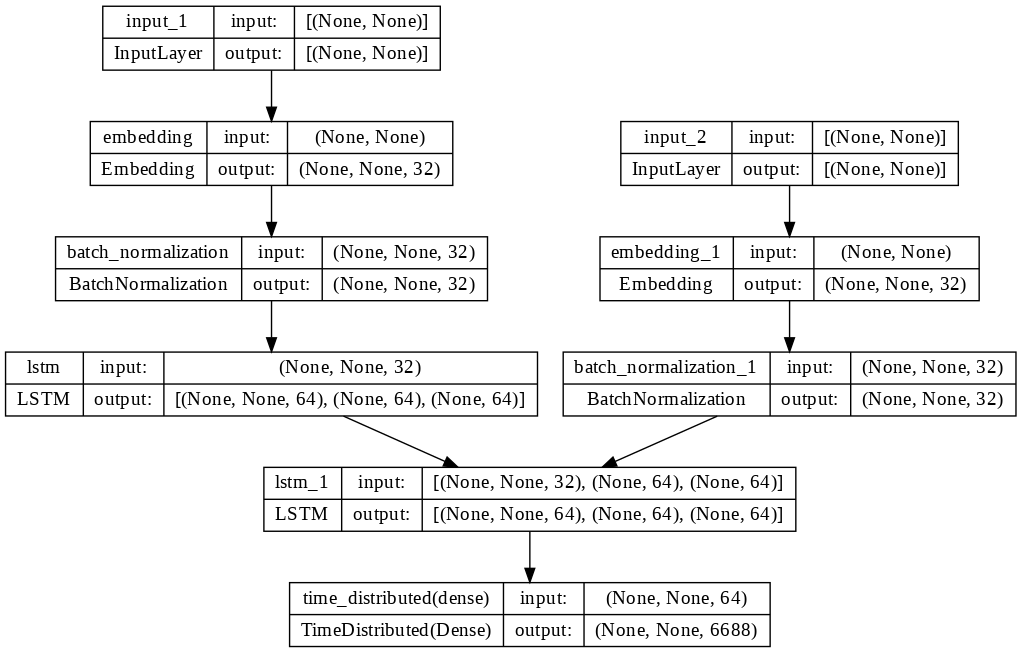

In [32]:
plot_model(model_imp,'model_imp.png',show_shapes=True,dpi=100)

Here we want to change our optimizers because we think that the SGD doesn't do a great job at our model. We used the `rmsprop` optimizer as it’s usually a good choice when working with recurrent neural networks from our research.

In [33]:
model_imp.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

#### **IMPROVEMENT MODEL TRAINING**

For our training, we increased our iterations to **50** in hopes of achieving better results.

In [34]:
improve_model_r = model_imp.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=50,
             batch_size=64,
             callbacks=[es,rl],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/50
235/235 [==============================] - 9s 25ms/step - loss: 3.4194 - accuracy: 0.5589 - val_loss: 2.7954 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 5s 21ms/step - loss: 2.3985 - accuracy: 0.6311 - val_loss: 2.3886 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 5s 21ms/step - loss: 2.2621 - accuracy: 0.6494 - val_loss: 2.2227 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 5s 22ms/step - loss: 2.1391 - accuracy: 0.6644 - val_loss: 2.1180 - val_accuracy: 0.6745 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 5s 21ms/step - loss: 2.0445 - accuracy: 0.6748 - val_loss: 2.0383 - val_accuracy: 0.6831 - lr: 0.0010
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 1.9725 - accuracy: 0.6835 - val_loss: 1.9783 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 7/50
235/235 [==============================] - 5s 21ms/st

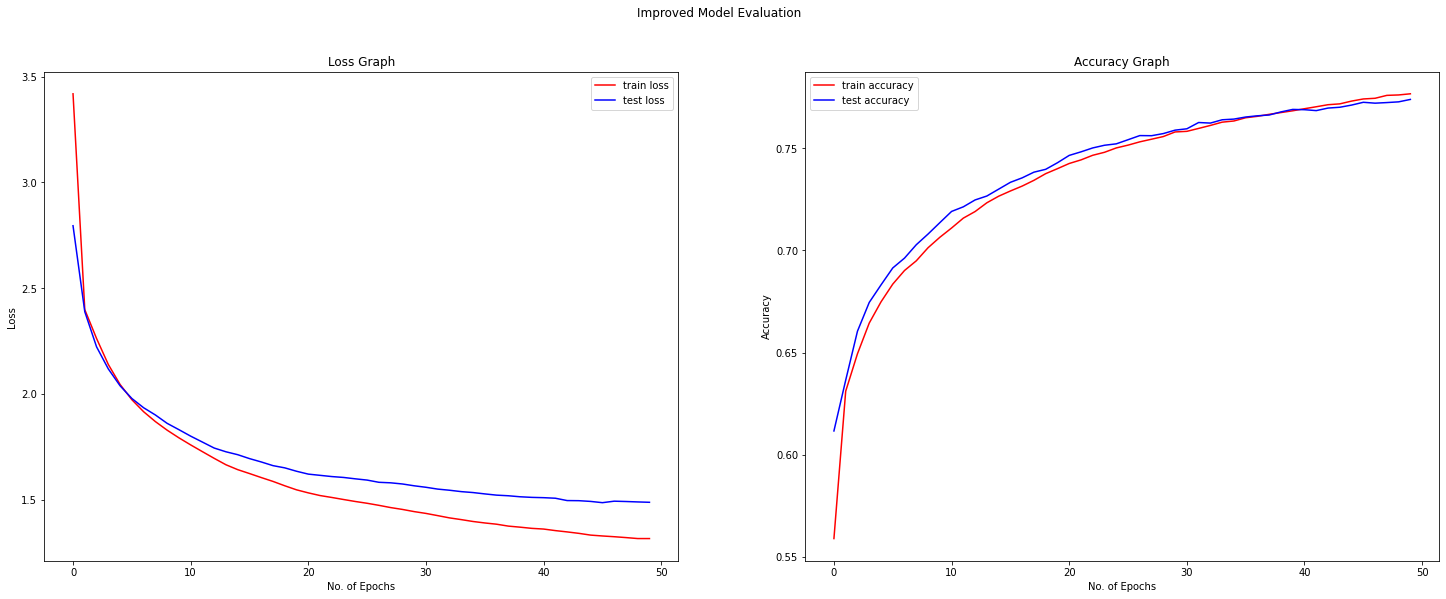

In [35]:
fig, ax = plt.subplots(1,2, figsize=(25,9))
plt.suptitle('Improved Model Evaluation')

plt.subplot(1,2,1)
plt.plot(improve_model_r.history['loss'],'r',label='train loss')
plt.plot(improve_model_r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

plt.subplot(1,2,2)
plt.plot(improve_model_r.history['accuracy'],'r',label='train accuracy')
plt.plot(improve_model_r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

plt.show()

Here the results in the improved model is we have a better performing model, with increased accuracy and lower loss. So we have achieved our objective at making the better model and improving from the baseline model.

#### **MODEL INFERENCE**

> In this section we want to do the same thing that we did in our preprocessing before, to later be able to predict translations.

First, we want to save the encoder model which is achieved by combining the inputs and the hidden and cell states of the encoder.

In [36]:
encoder_model = Model(encoder_inputs,encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          158912    
                                                                 
 batch_normalization (BatchN  (None, None, 32)         128       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 [(None, None, 64),        24832     
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
Total params: 183,872
Trainable params: 183,808
Non-trainable params: 64
____________________________________________________

Let's save them :

In [37]:
encoder_model.save('model_encoder.h5')

Now it's time for us to save our decoder model, we made a new hidden and cell states and combining them with the previously trained improved model. The end result is the model that accepts the decoder and state inputs and outputs the results based on the states of the decoder.

In [38]:
decoder_initial_state_h = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))

decoder_state_inputs = [decoder_initial_state_h, decoder_initial_state_c]

decoder_out, decoder_state_h, decoder_state_c = decoder_lstm(decoder_BN_3, initial_state=decoder_state_inputs)
decoder_states = [decoder_state_h, decoder_state_c]
decoder_final = decoder_dense(decoder_out)

decoder_model = Model(inputs = [decoder_inputs]+decoder_state_inputs, outputs=[decoder_final]+decoder_states)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     214016      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, None, 32)    128         ['embedding_1[0][0]']            
 rmalization)                                                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64)]         0           []                         

Now we want to save our decoder model

In [39]:
decoder_model.save('model_decoder.h5')

Here below is a code for our answer key retrieved from our tokenizer.

In [41]:
translated_words = dict((v,k) for k,v in nld_tokenizer.word_index.items())

Then we want to save the answer keys:

In [42]:
pickle.dump(translated_words, open('translated_tokenized_decoder.pkl', 'wb'))

Here below is our code of testing the performances of our model, we first create an example input text, and then we cleaned those text and pad them. Next we want to create a loop to then our decoder model is able to predict the input state and then finding the maximum arguments from our decoder.

In [43]:
text = 'i want to eat'
input_txt = clean_text(text)
inf = eng_tokenizer.texts_to_sequences([input_txt])
inf = pad_sequences( inf , maxlen=max_eng_len , padding='post' )

state_inf = encoder_model.predict(inf,verbose=0)

word = ''
sentences = []
target_seq = np.array([[nld_tokenizer.word_index['start']]])
while True:
  dec_out, h, c = decoder_model.predict([target_seq] + state_inf,verbose=0)

  wd_id = np.argmax(dec_out[0][0])
  word = translated_words[wd_id]
  sentences.append(word)

  target_seq = np.array([[wd_id]])
  state_inf = [h,c]

  if word == 'end' or len(sentences)>=15:
    
    if sentences[-1] == 'end':
      print(' '.join(sentences[:-1]))

    else:
      print(' '.join(sentences))
    break


ik wil graag eten


The results are promising, `'ik wil graag eten'` in dutch means `'i want to eat'` in English. so we have successfully created a translation model from english to dutch.

## **CONCLUSIONS**

**From our project of making the english to dutch translation, we could conclude that:**

1. We cleaned our texts from regular expressions that is irrelevant.

2. We tokenize sentences into words so the model could process the data better.

3. We then pad the sequences so it has the same input length

4. We are able to make the sequence 2 sequence encoder - decoder model.

5.  Sequence-to-Sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to German).
* Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, DNA sequence modeling, among others.
* For this particular project, we are using the sequence-to-sequence encoder - decoder model. What does the encoder & decoder do? 
    - Encoder : reads and encodes a source sentence into a fixed length vector
    - Decoder : Decoder then outputs a translation from the encoded vector (or known as context vectors)
* We also want to use the LSTM which which acts as the algorithm for our encode and decoding. The LSTM is a particular recurrent neural architecture independent of any application. It can be used for general sequence processing problems, from sequence classification to sequence transcoding and more. LSTMs can also be used to implement NMT, and they are an effective architecture for that purpose.

6. Eventhough we could see that in the inference that our model is able to predict and the outcome is great, a couple of sentence and complex word still could not be translated. This comes from the not so good accuracy averaging between 76 - 77% and high loss averaging between 1.1-1.3. This is reasonable, because this is the one deficiency factor of sequence 2 sequence models. This also comes to the lack of data entries of only 20.000 entries in each languages. So for future improvements we could add more data entries in order for our model to learn and predict better. This sequence 2 sequence model is also prone to lost informations, if the sequence is lengthy, then the loss would also be high.

7. In our work, we did a couple of improvements, like adding more LSTM layers, or defining more layer dropouts, but this comes to no good result. So the best model we achieved is the model that we explained in the model improvements section. The improvements that we did is batch normalization which is a technique to standardize the inputs to a network, applied to ether the activations of a prior layer or inputs directly. Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error. We also did some layer drouput which is a regularization technique that randomly ignores a subset of nodes in a given layer. It essentially prevents these dropped out nodes from participating in producing a prediction on the data.

8. Our improved model of 50 epochs has a training duration of 250 seconds, meaning we couldve add more data so our model could perform better.

